<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Homework/NGupta_homework8_with_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 8.
Utilize the Universal Sentence encoder to build a model for the following dataset.  Note--we want to POLARITY not Sentiment column, although the data is setup correctly already



# Load Libraries

In [1]:
import os
import re
from typing import List, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
print(tf.__version__)

2.3.0


# Load Data

In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

# Reduce logging output.
#tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,"Season after season, the players or characters...",10,1
1,I find Alan Jacobs review very accurate concer...,8,1
2,I saw Saving Grace right after it came out on ...,10,1
3,"Dreamquest is by far, the best porn movie I've...",10,1
4,I can't say much about this film. I think it s...,3,0


# Train and Validation Splits

In [3]:
# Create datasets (Only take up to 150 words for memory)
NUM_CHARS = 150
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:NUM_CHARS]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity']

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:NUM_CHARS]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity']

In [4]:
print(len(train_text), len(train_label))
print(len(test_text), len(test_label))

25000 25000
25000 25000


In [5]:
train_text[0].shape

(1,)

In [6]:
use_test = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
sentence_encoding = use_test(["This is a test of USE"])
sentence_encoding.shape

TensorShape([1, 512])

In [7]:
print(sentence_encoding)

tf.Tensor(
[[-8.41595232e-03 -5.61952703e-02 -4.07758318e-02 -2.94545945e-02
  -4.88133729e-02 -7.73191154e-02 -1.81259564e-03  3.17418166e-02
   4.34551425e-02  4.00216877e-03  1.36102820e-02 -1.15882112e-02
   6.16076216e-02 -2.87124584e-03  3.92416082e-02  2.57035792e-02
   2.41553877e-03  3.72053608e-02  1.08773699e-02 -5.01606390e-02
   3.74448746e-02 -2.02413765e-03 -5.03091924e-02 -1.17291445e-02
  -4.35480587e-02  1.77046638e-02  2.77202819e-02 -6.90487027e-02
   2.61135884e-02 -8.04910958e-02  4.13932502e-02 -8.80538151e-02
  -8.11734819e-04 -1.49555169e-02 -8.64357222e-03  8.20124075e-02
  -8.62774497e-04 -8.40719640e-02  2.60526314e-02  5.91145493e-02
  -2.58402415e-02 -4.03626189e-02 -2.41041593e-02 -3.43766361e-02
  -1.90319698e-02 -2.09738836e-02 -3.37156504e-02  2.57028062e-02
   2.88378075e-02 -4.60337326e-02  4.56407443e-02 -6.84338734e-02
  -1.07607335e-01 -1.13632744e-02  5.83538711e-02 -5.85528612e-02
   4.22572531e-02 -3.68575789e-02 -2.22314578e-02  7.40067810e-02

# Training

In [8]:
classes = set(list(set(train_label)) + list(set(test_label)))
classes

{0, 1}

In [9]:
NUM_CLASSES = len(classes)
NUM_CLASSES

2

In [10]:
def plot_metrics(history: tf.python.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [11]:
# After experimentation, I found that you can generally get a better validation accuracy id we allow the USE to be trainable.
# But this comes at the cost of training time. It is not appreciably high but higher nonetheless compared to trainable=False.
USE = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)

In [12]:
"""
OOPS I DELETED ALL MY CODE!!  I guess you have to build a network that will do sentiment analysis with 
the Universal Sentance Encoder (USE) from above!

Note that USE layer can be utilized with Sequential() or Model()
"""

# This is useful to debug the issues with input shape: https://github.com/tensorflow/hub/issues/526
input_text = Input(shape=[], name='sentence',dtype=tf.string)
embedding = USE(input_text)

# Model was overfitting, so I decided to add a dropout layer after the embedding as well
# This led to a small bump in the Validation accuracy. This could be removed if needed.
dropout = Dropout(0.2)(embedding) 
dense = Dense(100, activation='relu')(dropout)
dropout = Dropout(0.2)(dense)
pred = Dense(NUM_CLASSES, activation='softmax')(dropout)
model = Model(inputs=[input_text], outputs=pred)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence (InputLayer)        [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 256,849,326
Trainable params: 51,502
Non-trainable params: 256,797,824
___________________________________

In [13]:
# Sample
model.predict(tf.convert_to_tensor(["the cat is on the mat", "dogs are in the fog"]))

array([[0.45677698, 0.54322296],
       [0.49490967, 0.50509036]], dtype=float32)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0, patience=3)

from tensorflow.keras.callbacks import ModelCheckpoint
# add a checkpoint to save the lowest validation loss
filepath = '.'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

In [15]:
BATCH_SIZE = 64
EPOCHS = 10
history = model.fit(
    train_text, train_label,
    validation_data=(test_text, test_label),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[es, checkpoint]    
    )

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.7978
Epoch 00001: val_loss improved from inf to 0.38632, saving model to .
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 35s 89ms/step - loss: 0.4432 - accuracy: 0.7978 - val_loss: 0.3863 - val_accuracy: 0.8230
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8168
Epoch 00002: val_loss improved from 0.38632 to 0.38055, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 34s 87ms/step - loss: 0.3983 - accuracy: 0.8168 - val_loss: 0.3805 - val_accuracy: 0.8260
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8228
Epoch 00003: val_loss improved from 0.38055 to 0.37695, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 35s 89ms/step - loss: 0.3920 - accuracy: 0.8228 - val_loss: 0.3770 - val_accuracy: 0.8261
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.8244
Epoch 00004: val_loss did not improve from 0.37695
391/391 [==============================] - 26s 66ms/step - loss: 0.3851 - accuracy: 0.8244 - val_loss: 0.3873 - val_accuracy: 0.8208
Epoch 5/10
390/391 [============================>.] - ETA: 0s - loss: 0.3830 - accuracy: 0.8258
Epoch 00005: val_loss improved from 0.37695 to 0.37387, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 35s 90ms/step - loss: 0.3830 - accuracy: 0.8259 - val_loss: 0.3739 - val_accuracy: 0.8296
Epoch 6/10
391/391 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8324
Epoch 00006: val_loss improved from 0.37387 to 0.37173, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 35s 89ms/step - loss: 0.3740 - accuracy: 0.8324 - val_loss: 0.3717 - val_accuracy: 0.8291
Epoch 7/10
390/391 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8313
Epoch 00007: val_loss improved from 0.37173 to 0.37075, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 34s 87ms/step - loss: 0.3716 - accuracy: 0.8314 - val_loss: 0.3708 - val_accuracy: 0.8303
Epoch 8/10
391/391 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8384
Epoch 00008: val_loss improved from 0.37075 to 0.37058, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 35s 88ms/step - loss: 0.3656 - accuracy: 0.8384 - val_loss: 0.3706 - val_accuracy: 0.8302
Epoch 9/10
391/391 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8404
Epoch 00009: val_loss did not improve from 0.37058
391/391 [==============================] - 26s 66ms/step - loss: 0.3608 - accuracy: 0.8404 - val_loss: 0.3747 - val_accuracy: 0.8275
Epoch 10/10
391/391 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8406
Epoch 00010: val_loss improved from 0.37058 to 0.37013, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


391/391 [==============================] - 35s 89ms/step - loss: 0.3570 - accuracy: 0.8406 - val_loss: 0.3701 - val_accuracy: 0.8322


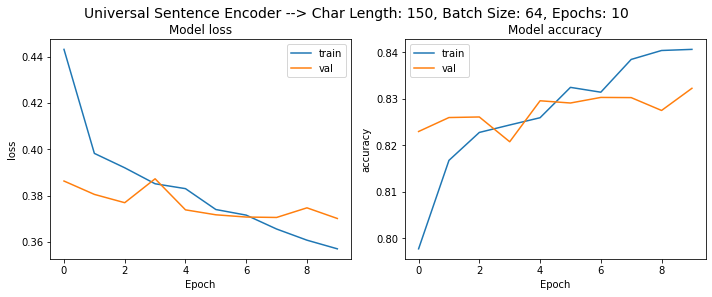

In [16]:
plot_metrics(
    history,
    metrics=['loss', 'accuracy'],
    title = f"Universal Sentence Encoder --> Char Length: {NUM_CHARS}, Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}")

# Prediction

In [17]:
# Sample
model.predict(tf.convert_to_tensor(["the cat is on the mat", "dogs are in the fog"]))

array([[0.5636076 , 0.43639246],
       [0.07358883, 0.9264112 ]], dtype=float32)

In [18]:
predictions = model.predict(test_text)
predictions[:5]

array([[0.0716339 , 0.92836607],
       [0.8928732 , 0.1071268 ],
       [0.8982558 , 0.10174423],
       [0.93427163, 0.06572835],
       [0.00458838, 0.9954116 ]], dtype=float32)

In [19]:
predictions_max = tf.math.argmax(predictions, axis=1)
predictions_max[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 1])>

In [20]:
test_label[0:5]

0    1
1    1
2    0
3    0
4    1
Name: polarity, dtype: int64

In [21]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_label, predictions_max)
m.result().numpy()

0.83224

In [22]:
predictions

array([[0.0716339 , 0.92836607],
       [0.8928732 , 0.1071268 ],
       [0.8982558 , 0.10174423],
       ...,
       [0.9794519 , 0.02054808],
       [0.9592803 , 0.04071963],
       [0.36615896, 0.633841  ]], dtype=float32)